In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! [ ! -d "/content/dataset/UTKFace" ] && unzip "/content/drive/MyDrive/Datasets/utkface.zip" -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.

In [3]:
dataset_folder_name = '/content/dataset/UTKFace'

IMG_WIDTH = IMG_HEIGHT = 200

In [4]:
import glob
import os
import random

filenames = glob.glob(os.path.join(dataset_folder_name, "*.%s" % 'jpg'))
random.shuffle(filenames)

In [5]:
from tensorflow.keras.utils import Sequence
import math
import numpy as np
from PIL import Image

class UTKFaceSequence(Sequence):

    def __init__(self, filenames, batch_size, shuffle=True):
        self.filenames = filenames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.filenames) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            random.shuffle(self.filenames)

    def __getitem__(self, idx):
        filenames = self.filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        x_data = []
        y_data = []
        for file in filenames:
            x, y = self.parse_info_from_file(file)
            x_data.append(x)
            y_data.append(y)
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        return x_data, y_data
    
    def get_labels(self):
        labels = []
        for filename in self.filenames:
            filename = os.path.split(filename)[1]
            filename = os.path.splitext(filename)[0]
            age = filename.split('_')[0]
            labels.append(int(age))
        return labels

    @staticmethod
    def parse_info_from_file(img_path):
        img = Image.open(img_path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  
        filename = os.path.split(img_path)[1]
        filename = os.path.splitext(filename)[0]
        
        # Normalization
        age = float(filename.split('_')[0]) / 116.0
        img = np.array(img) / 255.0

        return img, age

# Defining CNN-model

In [6]:
import tensorflow as tf

leaky_relu_negative_slope = 0.2

inputs = tf.keras.layers.Input(shape = [IMG_WIDTH] + [IMG_HEIGHT] + [ 3 ])

x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=1, use_bias=False, 
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_negative_slope)(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_negative_slope)(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_negative_slope)(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs, outputs)

model.summary()
# tf.keras.utils.plot_model( model , to_file='age_model_architecture.png', show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4608  

# Compiling the model

In [7]:
num_epochs = 50
batch_size = 128

filepath = 'saved_models/age_recognition_{epoch:02d}_{val_mae:.4f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, save_weights_only=False, monitor='val_mae')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

model.compile( 
    loss=tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mae', 'mse'])

# Training the model


In [8]:
!rm -rf 'saved_models'
!rm -rf 'age_recognition.h5'

TRAIN_TEST_SPLIT = 0.8
train_num_samples = int(len(filenames) * TRAIN_TEST_SPLIT)

train_data_generator = UTKFaceSequence(filenames[:train_num_samples], batch_size, shuffle=True)
test_data_generator = UTKFaceSequence(filenames[train_num_samples:], batch_size, shuffle=False)

history = model.fit( 
    x=train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_generator, 
    callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
149/149 [==============================] - 58s 295ms/step - loss: 10.6321 - mae: 0.1775 - mse: 0.0644 - val_loss: 1.0301 - val_mae: 0.1495 - val_mse: 0.0386
Epoch 2/50
149/149 [==============================] - 42s 282ms/step - loss: 0.4063 - mae: 0.0923 - mse: 0.0163 - val_loss: 0.1982 - val_mae: 0.1063 - val_mse: 0.0223
Epoch 3/50
149/149 [==============================] - 42s 284ms/step - loss: 0.1395 - mae: 0.0831 - mse: 0.0135 - val_loss: 0.1214 - val_mae: 0.0779 - val_mse: 0.0125
Epoch 4/50
149/149 [==============================] - 42s 283ms/step - loss: 0.1149 - mae: 0.0764 - mse: 0.0114 - val_loss: 0.1103 - val_mae: 0.0706 - val_mse: 0.0099
Epoch 5/50
149/149 [==============================] - 42s 282ms/step - loss: 0.1077 - mae: 0.0719 - mse: 0.0102 - val_loss: 0.1086 - val_mae: 0.0759 - val_mse: 0.0122
Epoch 6/50
149/149 [==============================] - 43s 287ms/step - loss: 0.1028 - mae: 0.0686 - mse: 0.0094 - val_loss: 0.1086 - val_mae: 0.0746 - val_mse: 0.00

# Saving the model

In [9]:
model.save('age_recognition.h5')

# Evaluating the model

In [10]:
model = tf.keras.models.load_model('age_recognition.h5')
model.evaluate(test_data_generator)

38/38 [==============================] - 8s 205ms/step - loss: 0.0818 - mae: 0.0538 - mse: 0.0057


[0.0818176120519638, 0.05383715406060219, 0.005701184738427401]

# Visualization of the results




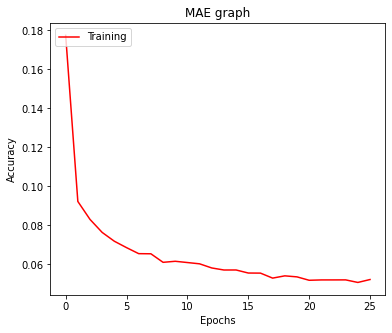

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(history.history['mae'], color='red', label='Training')
# plt.plot(history.history['val_mae'], color='green', label='Validation')

plt.title("MAE graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.show()

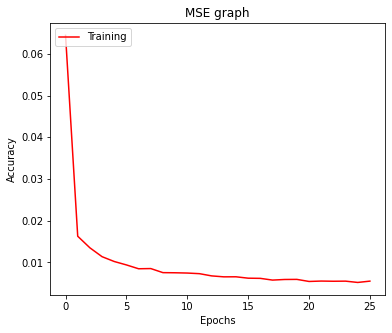

In [12]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['mse'], color='red', label='Training')
# plt.plot(history.history['val_mse'], color='green', label='Validation')

plt.title("MSE graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.show()

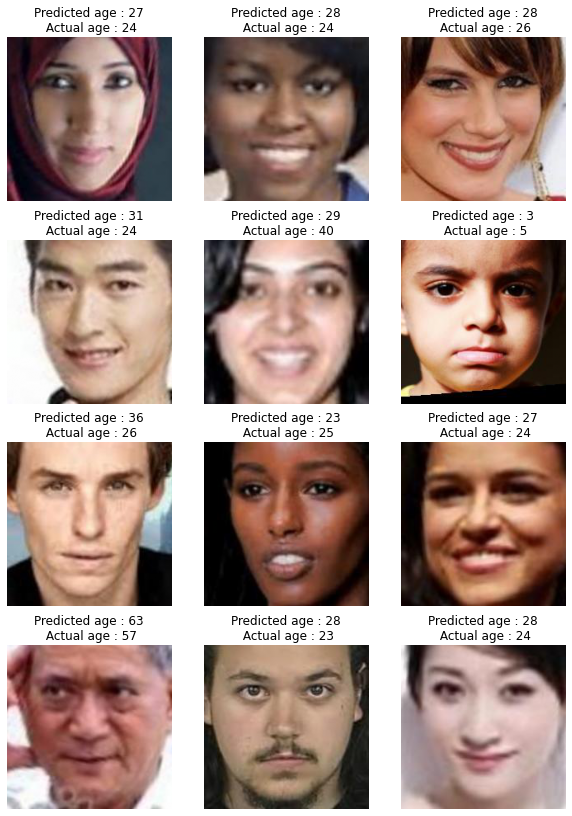

In [16]:
fig = plt.figure(figsize=(10 , 18))
x, y = test_data_generator.__getitem__(2)

for i, (image, label) in enumerate(zip(x[:12], y[:12])):
    fig.add_subplot(5, 3, i + 1)
    plt.imshow(image)
    prediction = round(model.predict(np.expand_dims(image , 0))[0][0] * 116)
    plt.axis('off')
    plt.title(f'Predicted age : {prediction}\n Actual age : {round(label * 116)}')

plt.show()